<h1><center> What's Policy Learning?

**Policy** is a function which maps current observation to an action. It is more direct way for an Agent to learn *good behaviour* by acting in the environment. The other way, **Q Learning**, learns a quantified value for being in a particular state $s$ and performing a particular action $a$. That helps in exploration, PL doesn't have that much of foresightedness since it doesn't consider long term rewards in choosing policy *(No Bellman equation)*. 

So, Policy Learning may be used for environments where reward is based on immediate action *(non-hysterical)*. 

$$\pi(s) \rightarrow a$$

___

## Toy application - Part I

Let's apply Policy learning to a **4-Armed Bandit problem**. 4-Armed Bandit is a slot machine with four levers. 
On pulling a lever, you might get some reward. These rewards vary for ever lever (fixed probabilities that are preprogrammed). Our goal is to find the best lever to pull in-order to maximize our total reward.

**Choosing an action** is like picking a lever to pull. So, we have 4 possible actions. 
Each action should be associated with a weight. This weight determines how ofter that action will be chosen. Thus, scrutinizing policy function.

**Loss function** should take reward & action into account and modify weight of action to re-establish the ground truth in Agent's knowledge base.

If $A$ is reward we get (called advantage) for $\pi$, the action we chose; 
$$loss = -\log(\pi) \cdot A$$

In [24]:
import tensorflow as tf
import numpy as np

# Ground-truth about the 4 levers
bandits = [4, 2.5, -4, 6]  # As per our reward fn., Bandit_id 2 yields max reward

# Let's define reward function
def get_reward(bandit_id):
    """ Takes Bandit index as input and returns 1 or -1 based on pre-established probability """
    
    if bandits[bandit_id] < np.random.randn():
        
        return 1
    else:
        
        return -1
    

# Neural Agent to learn that bandits policy function
policy = tf.Variable(np.ones([len(bandits)]))
get_action = tf.argmax(policy, 0)
reward = tf.placeholder(shape=1, dtype=tf.float64)
action = tf.placeholder(shape=1, dtype=tf.int32)               
policy_function_weight = tf.slice(policy, action, [1])  # Get the weight related to policy[action]
loss = -tf.log(policy_function_weight) * reward
                     
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
learn = trainer.minimize(loss)                     


# Setting up env and training Agent
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

episodes = 2000
all_rewards = []


for _ in range(episodes):
    accumulated_reward = 0
    action_ = sess.run(get_action)
    
    # Greedily pick a random action now and then <exploration>
    if np.random.rand() < 0.2:
        action_ = np.random.randint(4)
        
    reward_ = get_reward(action_)
    
    sess.run(learn, {action: [action_], reward: [reward_]})
    
    accumulated_reward += reward_
    all_rewards.append(accumulated_reward)
    
    
print "TRAINING ENDED"


TRAINING ENDED


In [25]:
# Check what the network has learned
sess.run(policy)

# Notice that 2nd bandit's policy value is the highest; which it should be
# Also notice that, since we were exploring a bit, the other policy values aligned to their 
# respective returns with 3rd index scoring least possible value

array([ 0.90559323,  0.89560604,  2.09731758,  0.8809805 ])

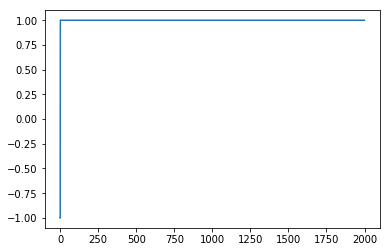

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(all_rewards)

### TODO

1. What happens if we randomly pick actions more often?

____

## Toy Application - Part II

Now a simpler expansion of this problem is to include *state dependence*. 
Part I dealt with simply learning policy assuming always in default state. Part II can be extended to have multiple slot machines, each with four levers to pull and the Agent has to figure out which slot-machine it has to choose and which lever to pull among the chosen - in a way that it maximizes the total reward.



In [24]:
import tensorflow as tf
import numpy as np

class BanditEnv(object):
    
    def __init__(self):
        # Ground-truth slot machine probabilites
        self.slot_machines = [[+1, +5, +8, -1], 
                              [+2, -9, +0, -2], 
                              [-1, -1, -1, +1]]
        
        
    def get_reward(self, state, action):
        
        if self.slot_machines[state][action] < np.random.randn():
            return +1
        
        else:
            return -1

        
# Neural Agent modelling

# Agent's representation of model
agent_env = tf.Variable(np.ones((3, 4)))
state = tf.placeholder(dtype=tf.int32)
action = tf.placeholder(dtype=tf.int32)
reward = tf.placeholder(dtype=tf.float64)
get_action = tf.argmax(agent_env)
agent_env_weight = tf.slice(agent_env, [state, action], [1, 1])
loss = -tf.log(agent_env_weight) * reward

trainer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
learn = trainer.minimize(loss)
        
        
# Training the agent
env = BanditEnv()
sess1 = tf.Session()
sess1.run(tf.global_variables_initializer())
episodes = 2000

for _ in range(episodes):
    
    # Get started by picking a random state 
    state_ = np.random.randint(3)
    
    # Get action for that state and chose greedily now and then
    action_ = sess1.run(get_action)[state_]
    if np.random.randn() < 0.3:
        action_ = np.random.randint(4)
    
    # Get reward for the duo
    reward_ = env.get_reward(state_, action_)
    #print sess1.run(loss, {reward: reward_, state: state_, action: action_})
    #print sess1.run(agent_env_weight, {reward: reward_, state: state_, action: action_})
    
    # Digest the reward_ and update agent_env
    sess1.run(learn, {reward: reward_, state: state_, action: action_})
    
print "Training Ended"
    
    

Training Ended


In [25]:
# Check what the network has learned
sess1.run(agent_env)

array([[-0.53011634, -0.38827324, -3.76474276,  1.57705525],
       [-2.46210834,  2.87238112,  1.01450545,  1.81829078],
       [ 1.589473  ,  1.59604155,  2.34793614, -5.75765858]])

### TODO 

1. See what happens if you don't greedily choose random actions once in a while